# LSTM Model Training

In [1]:
import sys
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

import tensorflow as tf

from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical




## Reading in the data

In [2]:
def lstm_data_transform(x_data, y_data, num_steps=3, num_ahead = 1):
    """ Changes data to the format for LSTM training for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    # for i in range(x_data.shape[0]):

    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps

        pred_ix = end_ix + num_ahead - 1

        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0] or pred_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[pred_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [23]:
df = pd.read_csv("../../data/processed/signalEUR_USD_Labelled_v3_processed.csv")
df["Date"] = pd.to_datetime(df["Date"])

# # Labels 3 days ahead
# df["label_3days"] = df["label"].shift(-3)

# # Labels 5 days ahead
# df["label_5days"] = df["label"].shift(-5)

df["Bollinger"] = (df["Price"] - df["sma"]) / (df["Bollinger_up"] - df["Bollinger_down"])
df["price_sma"] = df["Price"]  - df["sma"]
df["price_ema"] = df["Price"] - df["ema"]

In [24]:
def momentum(df, n=4):
    df["Momentum"] = np.nan

    for idx, row in df.iterrows():
        prev_idx = idx - n
        if prev_idx >= 0:
            curr_price = df.loc[idx, "Price"]
            prev_price = df.loc[prev_idx, "Price"]
            momentum = curr_price / prev_price * 100

            # Add the momentum
            df.loc[idx, "Momentum"] = momentum
    return df

In [25]:
df = momentum(df)

In [26]:
df

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,...,roc,rsi,Bollinger_up,Bollinger_down,cci,diff_n,Bollinger,price_sma,price_ema,Momentum
0,2013-01-01,1.3205,1.3194,1.3220,1.3180,0.07%,NaN,1.0,NaN,1.320500,...,NaN,NaN,NaN,NaN,NaN,-0.0122,NaN,NaN,0.000000,NaN
1,2013-01-02,1.3186,1.3205,1.3302,1.3157,-0.14%,-0.0019,1.0,NaN,1.318956,...,NaN,0.000000,NaN,NaN,NaN,-0.0122,NaN,NaN,-0.000356,NaN
2,2013-01-03,1.3048,1.3187,1.3192,1.3046,-1.05%,-0.0138,2.0,NaN,1.307931,...,NaN,0.000000,NaN,NaN,NaN,0.0223,NaN,NaN,-0.003131,NaN
3,2013-01-04,1.3069,1.3048,1.3091,1.2999,0.16%,0.0021,2.0,NaN,1.307136,...,NaN,13.559663,NaN,NaN,NaN,0.0275,NaN,NaN,-0.000236,NaN
4,2013-01-07,1.3117,1.3072,1.3121,1.3018,0.37%,0.0048,2.0,NaN,1.310649,...,NaN,36.329386,NaN,NaN,NaN,0.0266,NaN,NaN,0.001051,99.333586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,2021-12-27,1.1325,1.1318,1.1335,1.1302,0.07%,0.0008,0.0,1.130020,1.132357,...,0.004435,55.666956,1.135719,1.124321,64.885520,NaN,0.217597,0.002480,0.000143,100.372241
2345,2021-12-28,1.1309,1.1329,1.1335,1.1289,-0.14%,-0.0016,0.0,1.129885,1.131236,...,0.002304,51.038878,1.135350,1.124420,35.968157,NaN,0.092870,0.001015,-0.000336,99.867538
2346,2021-12-29,1.1348,1.1310,1.1370,1.1273,0.34%,0.0039,0.0,1.130030,1.133978,...,0.002119,60.317695,1.135861,1.124199,96.397770,NaN,0.408996,0.004770,0.000822,100.176554
2347,2021-12-30,1.1323,1.1349,1.1360,1.1298,-0.22%,-0.0025,0.0,1.130150,1.132687,...,-0.000441,52.902228,1.136068,1.124232,81.244514,NaN,0.181643,0.002150,-0.000387,100.053018


<AxesSubplot:xlabel='Date', ylabel='Momentum'>

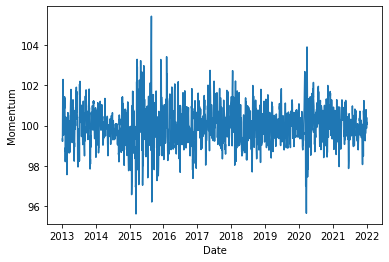

In [27]:
sns.lineplot(x="Date", y = "Momentum", data=df)

In [28]:
# Drop NA
df = df.dropna(axis = 0)
df = df.reset_index(drop=True)
df.head()

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,...,roc,rsi,Bollinger_up,Bollinger_down,cci,diff_n,Bollinger,price_sma,price_ema,Momentum
0,2013-02-15,1.3363,1.3363,1.3394,1.3306,0.01%,0.0002,1.0,1.344735,1.336730,...,-0.000150,39.939646,1.364281,1.325189,-62.849696,-0.0173,-0.215770,-0.008435,-0.000430,99.671813
1,2013-02-18,1.3352,1.3357,1.3377,1.3321,-0.08%,-0.0011,1.0,1.344925,1.335553,...,-0.004102,38.588551,1.363994,1.325856,-68.561252,-0.0290,-0.255002,-0.009725,-0.000353,99.241861
2,2013-02-19,1.3388,1.3352,1.3397,1.3329,0.27%,0.0036,1.0,1.345260,1.338051,...,-0.004906,45.544851,1.363601,1.326919,-57.039491,-0.0326,-0.176105,-0.006460,0.000749,99.516836
3,2013-02-20,1.3281,1.3387,1.3434,1.3270,-0.80%,-0.0107,1.0,1.345075,1.330396,...,-0.012785,32.802173,1.364052,1.326098,-90.131403,-0.0142,-0.447260,-0.016975,-0.002296,99.401242
4,2013-02-21,1.3189,1.3283,1.3291,1.3161,-0.69%,-0.0092,1.0,1.344140,1.321553,...,-0.012873,25.675429,1.366251,1.322029,-149.263447,-0.0133,-0.570750,-0.025240,-0.002653,98.697897


In [29]:
features = df.drop(labels =  ["Open", "High", "Low","Change %", "diff_1", "diff_n"], axis=1)
features.head()

,Date,Price,label,sma,ema,cma,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,Bollinger,price_sma,price_ema,Momentum
0,2013-02-15,1.3363,1.0,1.344735,1.336730,1.335315,0.002701,0.005461,-0.002760,-0.000150,39.939646,1.364281,1.325189,-62.849696,-0.215770,-0.008435,-0.000430,99.671813
1,2013-02-18,1.3352,1.0,1.344925,1.335553,1.335311,0.001906,0.004750,-0.002844,-0.004102,38.588551,1.363994,1.325856,-68.561252,-0.255002,-0.009725,-0.000353,99.241861
2,2013-02-19,1.3388,1.0,1.345260,1.338051,1.335408,0.001549,0.004109,-0.002561,-0.004906,45.544851,1.363601,1.326919,-57.039491,-0.176105,-0.006460,0.000749,99.516836
3,2013-02-20,1.3281,1.0,1.345075,1.330396,1.335211,0.000398,0.003367,-0.002969,-0.012785,32.802173,1.364052,1.326098,-90.131403,-0.447260,-0.016975,-0.002296,99.401242
4,2013-02-21,1.3189,1.0,1.344140,1.321553,1.334782,-0.001242,0.002445,-0.003688,-0.012873,25.675429,1.366251,1.322029,-149.263447,-0.570750,-0.025240,-0.002653,98.697897


In [30]:
X = features.drop(labels= ["Date"] + ["label"] + ["Price"] + ["macd_s", "macd_h", "sma", "ema", "cma", "Bollinger_up", "Bollinger_down", ], axis = 1)
X.head()

,macd,roc,rsi,cci,Bollinger,price_sma,price_ema,Momentum
0,0.002701,-0.000150,39.939646,-62.849696,-0.215770,-0.008435,-0.000430,99.671813
1,0.001906,-0.004102,38.588551,-68.561252,-0.255002,-0.009725,-0.000353,99.241861
2,0.001549,-0.004906,45.544851,-57.039491,-0.176105,-0.006460,0.000749,99.516836
3,0.000398,-0.012785,32.802173,-90.131403,-0.447260,-0.016975,-0.002296,99.401242
4,-0.001242,-0.012873,25.675429,-149.263447,-0.570750,-0.025240,-0.002653,98.697897


<AxesSubplot:xlabel='Date', ylabel='Bollinger'>

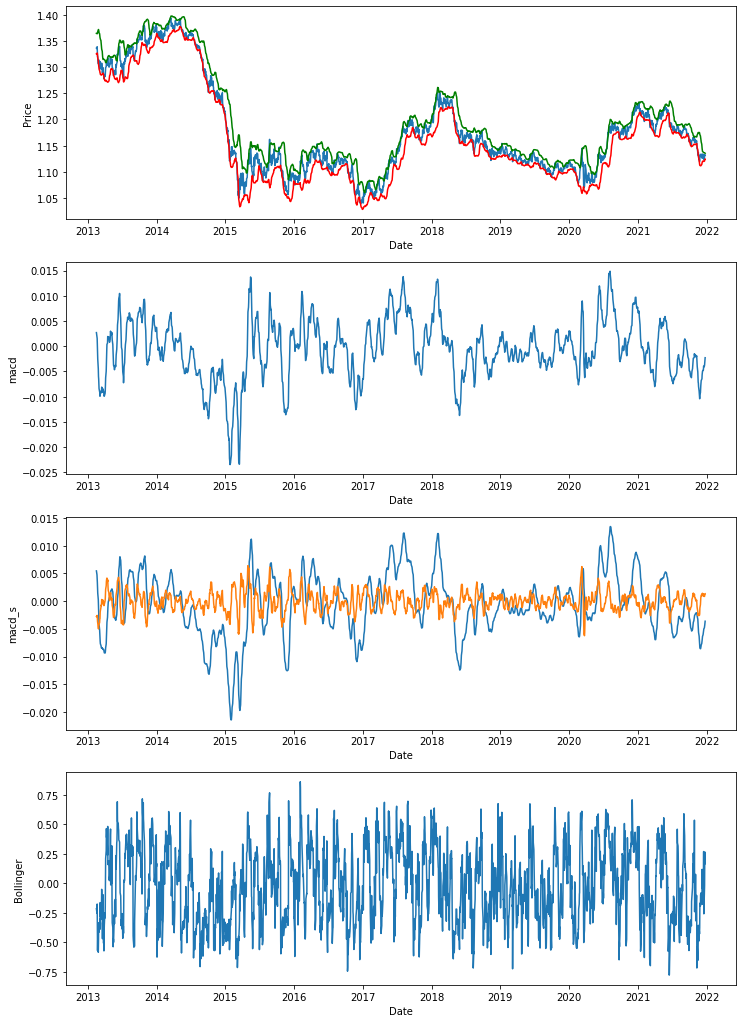

In [31]:
figure = plt.figure(figsize=(12,18))

ax1 = figure.add_subplot(4, 1, 1)
sns.lineplot(x="Date", y="Price", data=df, ax=ax1)
sns.lineplot(x="Date", y="Bollinger_up", data=df, ax=ax1, color="green")
sns.lineplot(x="Date", y="Bollinger_down", data=df, ax=ax1, color="red")

ax2 = figure.add_subplot(4, 1, 2)
sns.lineplot(x="Date", y = "macd", data=df, ax=ax2)


ax3 = figure.add_subplot(4, 1, 3)
sns.lineplot(x="Date", y = "macd_s", data=df, ax=ax3)
sns.lineplot(x="Date", y = "macd_h", data=df, ax=ax3)

ax4 = figure.add_subplot(4, 1, 4)
sns.lineplot(x="Date", y = "Bollinger", data=df, ax=ax4)

In [32]:
movement_df = df[df["label"] != 0]
# up = df[df["label"] == 2]

<AxesSubplot:xlabel='Date', ylabel='Price'>

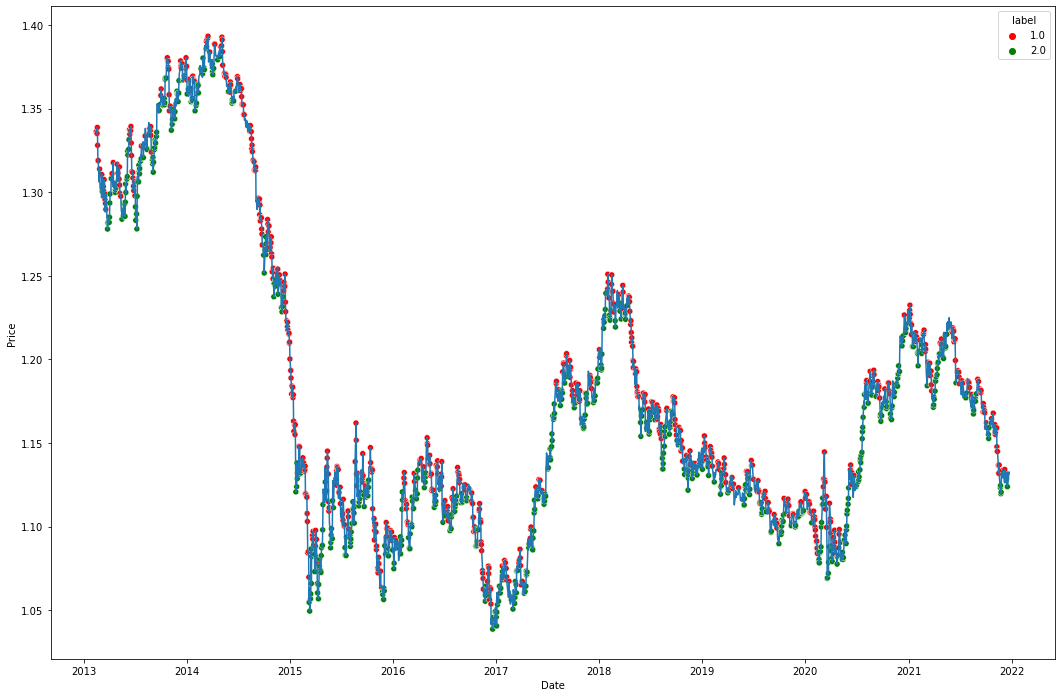

In [33]:
figure = plt.figure(figsize=(18,12))
sns.lineplot(x="Date", y="Price", data=df)
sns.scatterplot(x="Date", y="Price", data=movement_df, hue="label", palette=["red", "green"])

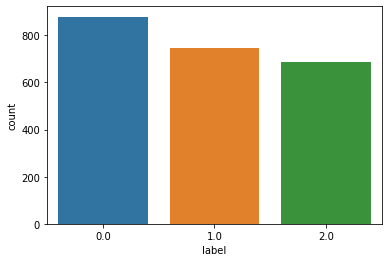

In [34]:
sns.countplot(x = "label", data=df)
plt.show()

## Data Preparation and Training

In [35]:
X = features.drop(labels= ["Date"] + ["label"] + ["Price"] + ["macd_s", "macd_h", "sma", "ema", "cma", "Bollinger_up", "Bollinger_down" ], axis = 1)
X.head()

,macd,roc,rsi,cci,Bollinger,price_sma,price_ema,Momentum
0,0.002701,-0.000150,39.939646,-62.849696,-0.215770,-0.008435,-0.000430,99.671813
1,0.001906,-0.004102,38.588551,-68.561252,-0.255002,-0.009725,-0.000353,99.241861
2,0.001549,-0.004906,45.544851,-57.039491,-0.176105,-0.006460,0.000749,99.516836
3,0.000398,-0.012785,32.802173,-90.131403,-0.447260,-0.016975,-0.002296,99.401242
4,-0.001242,-0.012873,25.675429,-149.263447,-0.570750,-0.025240,-0.002653,98.697897


In [36]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X

array([[ 0.56949337,  0.01564278, -0.55830574, ..., -0.58100351,
        -0.30909883, -0.32184695],
       [ 0.43303783, -0.36088872, -0.64375857, ..., -0.68034012,
        -0.25018069, -0.77842165],
       [ 0.37171601, -0.43740784, -0.20379279, ..., -0.42891838,
         0.59508117, -0.48641995],
       ...,
       [-0.43172872,  0.35910678,  0.4511993 , ...,  0.31187093,
         0.7956634 , -0.01083605],
       [-0.34391921,  0.02989785,  0.49623697, ...,  0.29569985,
         0.27018955,  0.86758005],
       [-0.28506771,  0.69101054,  0.32171798, ...,  0.21099421,
        -0.11649876,  0.4222322 ]])

In [37]:
y = tf.keras.utils.to_categorical(features["label"])

In [38]:
print(X.shape)
print(y.shape)

(2311, 8)
(2311, 3)


In [39]:
X_ds, y_ds = lstm_data_transform(X, y, num_steps=15, num_ahead=0)

print(X_ds.shape)
print(y_ds.shape)

(2296, 15, 8)
(2296, 3)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size=0.2, random_state=420)
print(X_train.shape, y_train.shape)
print( X_test.shape, y_test.shape)


# # Train Test Split
# TEST_SPLIT = 0.8

# X_train = X_ds[: int(len(X_ds) * TEST_SPLIT)]
# X_test = X_ds[int(len(X_ds) * TEST_SPLIT) : ]

# y_train = y_ds[:int(len(X_ds) * TEST_SPLIT)]
# y_test = y_ds[int(len(X_ds) * TEST_SPLIT):]

# print(X_train.shape)
# print(y_train.shape)

# print(X_test.shape)
# print(y_test.shape)


(1836, 15, 8) (1836, 3)
(460, 15, 8) (460, 3)


In [118]:
model = Sequential()

# model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), 
    # return_sequences=True, 
    dropout=0.2, 
    kernel_regularizer=tf.keras.regularizers.l2(0.005)
))
# model.add(Dropout(0.2))

# model.add(LSTM(units=128, return_sequences=True,
#     dropout=0.2, kernel_regularizer=tf.keras.regularizers.l2(0.005)
# ))
# model.add(Dropout(0.2))

# model.add(LSTM(units=50, return_sequences=True,
#     dropout=0.02, kernel_regularizer=tf.keras.regularizers.l2(0.0005)
# ))
# # model.add(Dropout(0.2))

# model.add(LSTM(units=64,
#     dropout=0.2, 
#     kernel_regularizer=tf.keras.regularizers.l2(0.005)
# ))
# model.add(Dropout(0.2))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))


model.add(Dense(3))
model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
model.summary()


# model = Sequential()

# # model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))

# model.add(LSTM(units=512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=256, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=128))
# model.add(Dropout(0.2))

# model.add(Dense(64))
# model.add(Dense(3, activation="softmax"))
# model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])
# model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 78,595
Trainable params: 78,595
Non-trainable params: 0
_________________________________________________________________


In [125]:
callbacks = []

callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=15,
                                            restore_best_weights=True))


In [126]:
epochs = 40

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32,
    callbacks= callbacks
)

Epoch 1/40
58/58 [==============================] - 1s 12ms/step - loss: 0.5992 - accuracy: 0.7598 - val_loss: 1.0465 - val_accuracy: 0.5609
Epoch 2/40
58/58 [==============================] - 1s 11ms/step - loss: 0.5572 - accuracy: 0.7821 - val_loss: 1.0362 - val_accuracy: 0.5739
Epoch 3/40
58/58 [==============================] - 1s 11ms/step - loss: 0.5488 - accuracy: 0.7941 - val_loss: 1.0244 - val_accuracy: 0.5891
Epoch 4/40
58/58 [==============================] - 1s 12ms/step - loss: 0.5232 - accuracy: 0.8056 - val_loss: 1.0341 - val_accuracy: 0.5761
Epoch 5/40
58/58 [==============================] - 1s 11ms/step - loss: 0.5359 - accuracy: 0.7843 - val_loss: 1.0542 - val_accuracy: 0.6000
Epoch 6/40
58/58 [==============================] - 1s 11ms/step - loss: 0.5483 - accuracy: 0.7756 - val_loss: 1.0877 - val_accuracy: 0.5826
Epoch 7/40
58/58 [==============================] - 1s 11ms/step - loss: 0.5175 - accuracy: 0.8017 - val_loss: 1.0627 - val_accuracy: 0.6000
Epoch 8/40
58

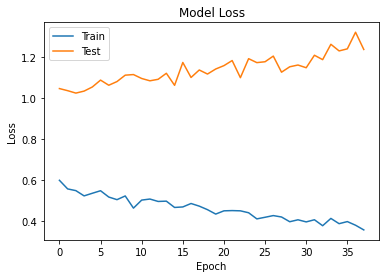

In [127]:
# Loss History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

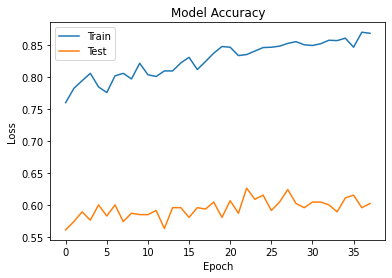

In [128]:
# Loss History
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [129]:
model.evaluate(x=X_test, y=y_test)

15/15 [==============================] - 0s 4ms/step - loss: 1.0995 - accuracy: 0.6261


[1.0995246171951294, 0.626086950302124]

In [130]:
test_pred = model.predict_classes(X_test)
test_actual = np.argmax(y_test, axis=1)

print(len(test_pred))
print(len(test_actual))

/Users/daniel/opt/anaconda3/envs/carrosell2/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


460
460


In [131]:
true_desc = 0
false_desc_noact = 0
false_desc_incr = 0

true_incr = 0
false_incr_noact = 0
false_incr_desc = 0

for pred, actual in zip(test_pred, test_actual):
    if pred == 2:
        # true_incr
        if actual == 2:
            true_incr += 1
        # false_incr_desc
        elif actual == 1: 
            false_incr_desc += 1
        # false_incr_noact
        else:
            false_incr_noact += 1
    elif pred == 1:
        # true_desc
        if actual == 1:
            true_desc += 1
        # false_desc_incr
        elif actual == 2: 
            false_desc_incr += 1
        # false_desc_noact
        else:
            false_desc_noact += 1


In [132]:
print(true_desc, false_desc_noact, false_desc_incr)
print(true_incr, false_incr_noact, false_incr_desc)

101 35 11
75 38 8


In [133]:
profit_accuracy_score = (true_desc + true_incr) / (true_desc + false_desc_noact + false_desc_incr + 
true_incr + false_incr_noact + false_incr_desc)

profit_accuracy_score

0.6567164179104478

In [136]:
THRESHOLD = 0.0055
MONEY = 10000

total = true_desc + false_desc_noact + false_desc_incr + true_incr + false_incr_noact + false_incr_desc

expected_gain = (true_desc + true_incr) / total * THRESHOLD
expected_nochange = (false_desc_noact + false_incr_noact) / total * 0
expected_loss = (false_desc_incr + false_incr_desc) / total * (-THRESHOLD)

expected_net_return_per_trade = expected_gain + expected_nochange + expected_loss
# expected_net_return = (MONEY / df['Price'].median()) * expected_net_return_per_trade * total
expected_net_return = (MONEY ) * expected_net_return_per_trade * total

# Test dataset consist of dates mid March 2020 - end Dec 2021
annualised_roi = (expected_net_return / MONEY + 1) ** (1/2) - 1

print("Expected Net Return from Mar 2020 - Dec 2021 with $10,000:", expected_net_return)
print(f"Annualised Rate of Return: {annualised_roi * 100:.5f}%")


Expected Net Return from Mar 2020 - Dec 2021 with $10,000: 8635.0
Annualised Rate of Return: 36.51007%


## Back-Test the Model

In [207]:
# Testing Algorithm on test data
START_DATE = "2020-03-15"
END_DATE = "2021-12-24"

N_STEPS = 15
N_AHEAD = 5

MONEY = 10000

CURR_POSITION = 0
POSITION_PRICE = 0

PROFIT = 0

mask = (df["Date"] >START_DATE) & (df["Date"] <= END_DATE)
test_df = df.loc[mask].reset_index(drop = True)

# test_features = test_df.drop(labels =  ["Open", "High", "Low","Change %", "diff_1", "diff_n"], axis=1)

dates = []
curr_profit = []

curr_steps = N_AHEAD

for idx, row in test_df.iloc[N_STEPS:,].iterrows():

    # Update position trackers
    if curr_steps > 0:
        curr_steps -= 1
    # Realise profit
    elif curr_steps == 0 and CURR_POSITION != 0:
        PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION
        CURR_POSITION = 0
        POSITION_PRICE = 0


    start_idx = idx - N_STEPS
    end_idx = idx - 1

    # Get the features
    pred_X = test_df.loc[start_idx:end_idx, ["macd", "roc",	"rsi", "cci", "Bollinger", "price_sma", "price_ema", "Momentum"]]

    # Transform using the scaler
    pred_X = scaler.transform(pred_X)

    # Reshape for model prediction
    pred_X= pred_X.reshape((1, pred_X.shape[0], pred_X.shape[1]))

    # Model prediction
    pred = model.predict(pred_X, verbose=0)
    pred = pred[0]
    pred = np.argmax(pred)

    curr_price = row["Price"]

    # Make buy/sell/hold decision
    # If prediction is increase
    if pred == 2:
        # Check our current position
        # If no hold, buy in
        if CURR_POSITION == 0:
            CURR_POSITION = MONEY / curr_price
            POSITION_PRICE = curr_price
            curr_steps = N_AHEAD

        # If in short, buy back and go long
        elif CURR_POSITION < 0:
            # Update profit on previous trade
            PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION

            # Now, we go long
            CURR_POSITION = MONEY / curr_price
            POSITION_PRICE = curr_price
            curr_steps = N_AHEAD
        
        # If in long, release gains and go long
        else:
            # Update profit on previous trade
            PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION

            # Now, we go long
            CURR_POSITION = MONEY / curr_price
            POSITION_PRICE = curr_price
            curr_steps = N_AHEAD

    # If prediction is decrease
    elif pred == 1:
        # Check our current position
        # If no hold, short sell
        if CURR_POSITION == 0:
            CURR_POSITION = - MONEY / curr_price
            POSITION_PRICE = curr_price
            curr_steps = N_AHEAD

        # If in short, realise gains and short sell
        elif CURR_POSITION < 0:
            # Update profit on previous trade
            PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION

            # Now, we go short
            CURR_POSITION = - MONEY / curr_price
            POSITION_PRICE = curr_price
            curr_steps = N_AHEAD
        
        # If in long, realise gains and go short
        else:
            # Update profit on previous trade
            PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION

            # Now, we go short
            CURR_POSITION = - MONEY / curr_price
            POSITION_PRICE = curr_price
            curr_steps = N_AHEAD

    # Keep track of profit
    dates.append(row["Date"])
    curr_profit.append(PROFIT)


In [208]:
result_df = pd.DataFrame({"Date": dates, "Profit": curr_profit})

<AxesSubplot:xlabel='Date', ylabel='Profit'>

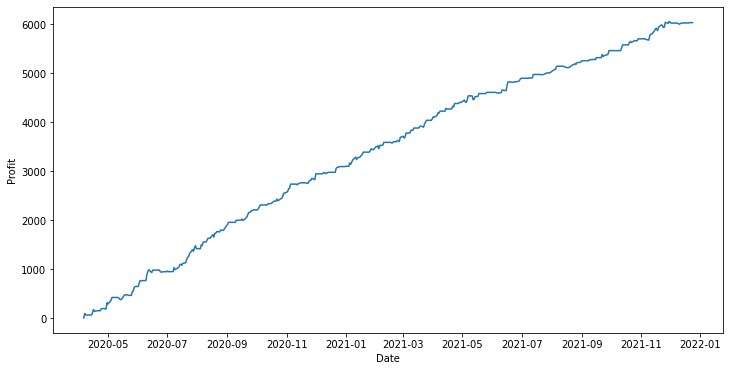

In [212]:
figure = plt.figure(figsize=(12,6))
sns.lineplot(x="Date", y="Profit", data=result_df)

<AxesSubplot:xlabel='Date', ylabel='Price'>

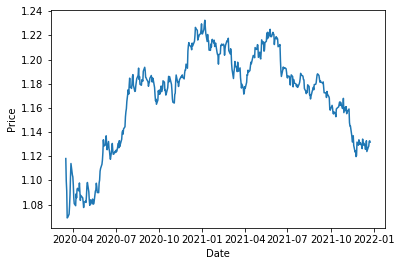

In [210]:
sns.lineplot(x="Date", y="Price", data=test_df)

In [223]:
expected_net_return = result_df.iloc[-1, 1]

num_years = (pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)) / timedelta(days=365)

annualised_roi = (expected_net_return / MONEY + 1) ** (1 / num_years) - 1

print(f"Expected Net Return from Mar 2020 - Dec 2021 with $10,000: ${expected_net_return:.2f}")
print(f"Annualised Rate of Return: {annualised_roi * 100:.5f}%")

Expected Net Return from Mar 2020 - Dec 2021 with $10,000: $6031.13
Annualised Rate of Return: 30.39850%


In [166]:
test_df.iloc[15:,]

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,...,roc,rsi,Bollinger_up,Bollinger_down,cci,diff_n,Bollinger,price_sma,price_ema,Momentum
15,2020-04-06,1.0791,1.0813,1.0835,1.0768,-0.16%,-0.0017,2.0,1.096780,1.079899,...,-0.023085,35.581245,1.134243,1.059317,-64.900443,0.0122,-0.235964,-0.017680,-0.000799,97.842053
16,2020-04-07,1.0889,1.0793,1.0926,1.0783,0.91%,0.0098,2.0,1.094830,1.086823,...,-0.012694,46.799889,1.129423,1.060237,-35.470948,0.0090,-0.085711,-0.005930,0.002077,99.334063
17,2020-04-08,1.0856,1.0891,1.0904,1.0829,-0.30%,-0.0033,0.0,1.092775,1.085882,...,-0.009670,43.833872,1.124128,1.061422,-31.820172,0.0051,-0.114423,-0.007175,-0.000282,100.000000
18,2020-04-09,1.0927,1.0857,1.0953,1.0841,0.65%,0.0071,1.0,1.091495,1.091127,...,0.006540,51.469366,1.120460,1.062530,-5.464806,-0.0092,0.020801,0.001205,0.001573,101.101036
19,2020-04-10,1.0935,1.0930,1.0953,1.0919,0.07%,0.0008,1.0,1.090645,1.092952,...,0.011751,52.312214,1.118226,1.063064,15.089952,-0.0059,0.051757,0.002855,0.000548,101.334445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2021-12-20,1.1275,1.1242,1.1305,1.1234,0.32%,0.0036,0.0,1.128420,1.127084,...,-0.000709,46.839553,1.136446,1.120394,-27.330869,0.0050,-0.057311,-0.000920,0.000416,100.159901
461,2021-12-21,1.1283,1.1277,1.1303,1.1260,0.07%,0.0008,0.0,1.128605,1.128019,...,0.002310,48.373952,1.136429,1.120781,-9.274996,0.0026,-0.019492,-0.000305,0.000281,99.982277
462,2021-12-22,1.1324,1.1279,1.1343,1.1264,0.36%,0.0041,0.0,1.129240,1.131389,...,0.003456,55.900932,1.136011,1.122469,47.075103,0.0024,0.233339,0.003160,0.001011,99.964689
463,2021-12-23,1.1328,1.1325,1.1343,1.1289,0.04%,0.0004,0.0,1.129850,1.132474,...,0.000000,56.613022,1.135439,1.124261,77.106303,-0.0005,0.263916,0.002950,0.000326,100.791885


## Saving the Model

In [135]:
MODEL_PATH = "../../results/models/Signal_LSTM_v3.8"

model.save(MODEL_PATH)
dump(scaler, os.path.join(MODEL_PATH, "scaler.save"))

INFO:tensorflow:Assets written to: ../../results/models/Signal_LSTM_v3.8/assets


INFO:tensorflow:Assets written to: ../../results/models/Signal_LSTM_v3.8/assets


['../../results/models/Signal_LSTM_v3.8/scaler.save']

# Model Evaluation

##  Loading the Model

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
PATH_TO_LOAD = "../../results/models/Signal_LSTM_v3.6"

In [15]:
df = pd.read_csv("../../data/processed/signalEUR_USD_Labelled_v1_processed.csv", index_col=0)
df["Date"] = pd.to_datetime(df["Date"])
test_df = df.iloc[-462 - 5:]

In [16]:
loaded_scaler = load(os.path.join(PATH_TO_LOAD, "scaler.save"))
loaded_model = tf.keras.models.load_model(PATH_TO_LOAD)

2022-04-09 16:27:36.139277: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-09 16:27:36.139527: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [41]:
pred = loaded_model.predict(X_test)

2022-04-09 16:29:15.317947: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [42]:
temp_actual = np.argmax(y_test, axis=1)
temp_pred = np.argmax(pred, axis=1)

In [43]:
accuracy_score(temp_actual, temp_pred)

0.6760869565217391

In [44]:
true_desc = 0
false_desc_noact = 0
false_desc_incr = 0

true_incr = 0
false_incr_noact = 0
false_incr_desc = 0

for pred, actual in zip(temp_pred, temp_actual):
    if pred == 2:
        # true_incr
        if actual == 2:
            true_incr += 1
        # false_incr_desc
        elif actual == 1: 
            false_incr_desc += 1
        # false_incr_noact
        else:
            false_incr_noact += 1
    elif pred == 1:
        # true_desc
        if actual == 1:
            true_desc += 1
        # false_desc_incr
        elif actual == 2: 
            false_desc_incr += 1
        # false_desc_noact
        else:
            false_desc_noact += 1

print(true_desc, false_desc_noact, false_desc_incr)
print(true_incr, false_incr_noact, false_incr_desc)

111 32 15
86 39 10


In [45]:
profit_accuracy_score = (true_desc + true_incr) / (true_desc + false_desc_noact + false_desc_incr + 
true_incr + false_incr_noact + false_incr_desc)

profit_accuracy_score

0.6723549488054608

In [46]:
THRESHOLD = 0.0055
MONEY = 10000

total = true_desc + false_desc_noact + false_desc_incr + true_incr + false_incr_noact + false_incr_desc

expected_gain = (true_desc + true_incr) / total * THRESHOLD
expected_nochange = (false_desc_noact + false_incr_noact) / total * 0
expected_loss = (false_desc_incr + false_incr_desc) / total * (-THRESHOLD)

expected_net_return_per_trade = expected_gain + expected_nochange + expected_loss
# expected_net_return = (MONEY / df['Price'].median()) * expected_net_return_per_trade * total
expected_net_return = (MONEY ) * expected_net_return_per_trade * total

# Test dataset consist of dates mid March 2020 - end Dec 2021
annualised_roi = (expected_net_return / MONEY + 1) ** (1/2) - 1

print("Expected Net Return from Mar 2020 - Dec 2021 with $10,000:", expected_net_return)
print(f"Annualised Rate of Return: {annualised_roi * 100:.5f}%")

Expected Net Return from Mar 2020 - Dec 2021 with $10,000: 9460.0
Annualised Rate of Return: 39.49910%


## Back-Test the Loaded Model

In [66]:
# Testing Algorithm on test data
START_DATE = "2020-03-15"
END_DATE = "2021-12-24"

N_STEPS = 15
N_AHEAD = 5

MONEY = 10000
TRANSACTION_COST = 0.0006

CURR_POSITION = 0
POSITION_PRICE = 0

PROFIT = 0

mask = (df["Date"] >START_DATE) & (df["Date"] <= END_DATE)
test_df = df.loc[mask].reset_index(drop = True)

# test_features = test_df.drop(labels =  ["Open", "High", "Low","Change %", "diff_1", "diff_n"], axis=1)

dates = []
curr_profit = []

curr_steps = N_AHEAD

for idx, row in test_df.iloc[N_STEPS:,].iterrows():

    # Update position trackers
    if curr_steps > 0:
        curr_steps -= 1
    # Realise profit
    elif curr_steps == 0 and CURR_POSITION != 0:
        PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION
        CURR_POSITION = 0
        POSITION_PRICE = 0


    start_idx = idx - N_STEPS
    end_idx = idx - 1

    # Get the features
    pred_X = test_df.loc[start_idx:end_idx, ["macd", "roc",	"rsi", "cci", "Bollinger", "price_sma", "price_ema", "Momentum"]]

    # Transform using the scaler
    pred_X = loaded_scaler.transform(pred_X)

    # Reshape for model prediction
    pred_X= pred_X.reshape((1, pred_X.shape[0], pred_X.shape[1]))

    # Model prediction
    pred = loaded_model.predict(pred_X, verbose=0)
    pred = pred[0]
    pred = np.argmax(pred)

    curr_price = row["Price"]

    # Make buy/sell/hold decision
    # If prediction is increase
    if pred == 2:
        # Check our current position
        # If no hold, buy in
        if CURR_POSITION == 0:
            CURR_POSITION = MONEY / curr_price
            POSITION_PRICE = curr_price
            curr_steps = N_AHEAD

        # If in short, buy back and go long
        elif CURR_POSITION < 0:
            # Update profit on previous trade
            PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION - (TRANSACTION_COST * np.abs(CURR_POSITION))

            # Now, we go long
            CURR_POSITION = MONEY / curr_price
            POSITION_PRICE = curr_price
            curr_steps = N_AHEAD
        
        # If in long, release gains and go long
        else:
            # Update profit on previous trade
            PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION - (TRANSACTION_COST * np.abs(CURR_POSITION))

            # Now, we go long
            CURR_POSITION = MONEY / curr_price
            POSITION_PRICE = curr_price
            curr_steps = N_AHEAD

    # If prediction is decrease
    elif pred == 1:
        # Check our current position
        # If no hold, short sell
        if CURR_POSITION == 0:
            CURR_POSITION = - MONEY / curr_price
            POSITION_PRICE = curr_price
            curr_steps = N_AHEAD

        # If in short, realise gains and short sell
        elif CURR_POSITION < 0:
            # Update profit on previous trade
            PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION - (TRANSACTION_COST * np.abs(CURR_POSITION))

            # Now, we go short
            CURR_POSITION = - MONEY / curr_price
            POSITION_PRICE = curr_price
            curr_steps = N_AHEAD
        
        # If in long, realise gains and go short
        else:
            # Update profit on previous trade
            PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION - (TRANSACTION_COST * np.abs(CURR_POSITION))

            # Now, we go short
            CURR_POSITION = - MONEY / curr_price
            POSITION_PRICE = curr_price
            curr_steps = N_AHEAD

    # Keep track of profit
    dates.append(row["Date"])
    curr_profit.append(PROFIT)


In [67]:
result_df = pd.DataFrame({"Date": dates, "Profit": curr_profit})
result_df

,Date,Profit
0,2020-04-06,0.000000
1,2020-04-07,85.256232
2,2020-04-08,85.256232
3,2020-04-09,114.643687
4,2020-04-10,101.831387
...,...,...
445,2021-12-20,4563.880373
446,2021-12-21,4563.880373
447,2021-12-22,4563.880373
448,2021-12-23,4563.880373


<AxesSubplot:xlabel='Date', ylabel='Profit'>

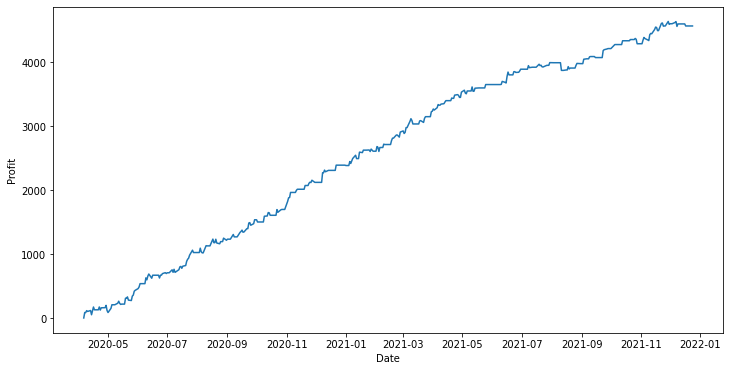

In [68]:
figure = plt.figure(figsize=(12,6))
sns.lineplot(x="Date", y="Profit", data=result_df)

<AxesSubplot:xlabel='Date', ylabel='Price'>

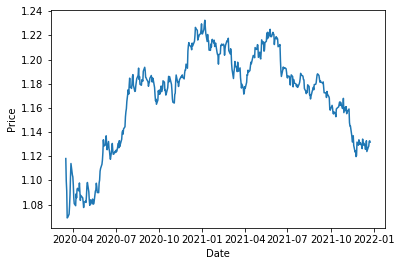

In [69]:
sns.lineplot(x="Date", y="Price", data=test_df)

In [70]:
expected_net_return = result_df.iloc[-1, 1]

num_years = (pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)) / timedelta(days=365)

annualised_roi = (expected_net_return / MONEY + 1) ** (1 / num_years) - 1

print(f"Expected Net Return from Mar 2020 - Dec 2021 with $10,000: ${expected_net_return:.2f}")
print(f"Annualised Rate of Return: {annualised_roi * 100:.5f}%")

Expected Net Return from Mar 2020 - Dec 2021 with $10,000: $4563.88
Annualised Rate of Return: 23.54570%


In [ ]:
test_df.iloc[15:,]

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,...,roc,rsi,Bollinger_up,Bollinger_down,cci,diff_n,Bollinger,price_sma,price_ema,Momentum
15,2020-04-06,1.0791,1.0813,1.0835,1.0768,-0.16%,-0.0017,2.0,1.096780,1.079899,...,-0.023085,35.581245,1.134243,1.059317,-64.900443,0.0122,-0.235964,-0.017680,-0.000799,97.842053
16,2020-04-07,1.0889,1.0793,1.0926,1.0783,0.91%,0.0098,2.0,1.094830,1.086823,...,-0.012694,46.799889,1.129423,1.060237,-35.470948,0.0090,-0.085711,-0.005930,0.002077,99.334063
17,2020-04-08,1.0856,1.0891,1.0904,1.0829,-0.30%,-0.0033,0.0,1.092775,1.085882,...,-0.009670,43.833872,1.124128,1.061422,-31.820172,0.0051,-0.114423,-0.007175,-0.000282,100.000000
18,2020-04-09,1.0927,1.0857,1.0953,1.0841,0.65%,0.0071,1.0,1.091495,1.091127,...,0.006540,51.469366,1.120460,1.062530,-5.464806,-0.0092,0.020801,0.001205,0.001573,101.101036
19,2020-04-10,1.0935,1.0930,1.0953,1.0919,0.07%,0.0008,1.0,1.090645,1.092952,...,0.011751,52.312214,1.118226,1.063064,15.089952,-0.0059,0.051757,0.002855,0.000548,101.334445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2021-12-20,1.1275,1.1242,1.1305,1.1234,0.32%,0.0036,0.0,1.128420,1.127084,...,-0.000709,46.839553,1.136446,1.120394,-27.330869,0.0050,-0.057311,-0.000920,0.000416,100.159901
461,2021-12-21,1.1283,1.1277,1.1303,1.1260,0.07%,0.0008,0.0,1.128605,1.128019,...,0.002310,48.373952,1.136429,1.120781,-9.274996,0.0026,-0.019492,-0.000305,0.000281,99.982277
462,2021-12-22,1.1324,1.1279,1.1343,1.1264,0.36%,0.0041,0.0,1.129240,1.131389,...,0.003456,55.900932,1.136011,1.122469,47.075103,0.0024,0.233339,0.003160,0.001011,99.964689
463,2021-12-23,1.1328,1.1325,1.1343,1.1289,0.04%,0.0004,0.0,1.129850,1.132474,...,0.000000,56.613022,1.135439,1.124261,77.106303,-0.0005,0.263916,0.002950,0.000326,100.791885


In [256]:
temp_x = features.drop(labels= ["Date"] + ["label", "label_3days", "label_5days"] + ["Price"], axis = 1)

In [258]:
temp_x.columns

Index(['sma', 'ema', 'cma', 'macd', 'macd_s', 'macd_h', 'roc', 'rsi',
       'Bollinger_up', 'Bollinger_down', 'cci'],
      dtype='object')

In [260]:
temp_x_transformed = loaded_scaler.transform(temp_x)

In [263]:
np.array_equal(temp_x_transformed, X)

True

In [265]:
df.tail()

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,...,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,label_3days,label_5days
2306,2021-12-20,1.1275,1.1242,1.1305,1.1234,0.32%,0.0036,2.0,1.128420,1.127084,...,-0.003948,-0.004795,0.000847,-0.000709,46.839553,1.136446,1.120394,-27.330869,0.0,0.0
2307,2021-12-21,1.1283,1.1277,1.1303,1.1260,0.07%,0.0008,0.0,1.128605,1.128019,...,-0.003696,-0.004575,0.000879,0.002310,48.373952,1.136429,1.120781,-9.274996,0.0,0.0
2308,2021-12-22,1.1324,1.1279,1.1343,1.1264,0.36%,0.0041,2.0,1.129240,1.131389,...,-0.003130,-0.004286,0.001156,0.003456,55.900932,1.136011,1.122469,47.075103,0.0,2.0
2309,2021-12-23,1.1328,1.1325,1.1343,1.1289,0.04%,0.0004,0.0,1.129850,1.132474,...,-0.002618,-0.003952,0.001334,0.000000,56.613022,1.135439,1.124261,77.106303,0.0,1.0
2310,2021-12-24,1.1317,1.1330,1.1344,1.1303,-0.10%,-0.0011,0.0,1.129850,1.131879,...,-0.002276,-0.003617,0.001341,0.006940,53.853702,1.135439,1.124261,73.581941,2.0,2.0


# Testing Code

In [298]:
sys.path.append("../../src/")
# from Signal_LSTM import predict
import Signal_LSTM

In [299]:
PATH_TO_LOAD = "../../results/models/Signal_LSTM_v1"

In [300]:
sys.modules["Signal_LSTM"]

<module 'Signal_LSTM' from '../../src/Signal_LSTM.py'>

In [468]:
import importlib
importlib.reload(Signal_LSTM)

<module 'Signal_LSTM' from '../../src/Signal_LSTM.py'>

In [341]:
df = pd.read_csv("../../data/processed/signalEUR_USD_Labelled_v1_processed.csv", index_col=0)
df["Date"] = pd.to_datetime(df["Date"])

In [469]:
test_df = df.iloc[-462 - 5:]

In [473]:
result_df = Signal_LSTM.predict(test_df, path = PATH_TO_LOAD)
result_df

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,cma,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,Pred
1882,2020-03-19,1.0690,1.0915,1.0982,1.0654,-2.04%,-0.0223,1.0,1.107490,1.074800,1.183894,-0.000745,0.003931,-0.004676,-0.044085,23.877925,1.145800,1.069180,-108.697395,NaN
1883,2020-03-20,1.0694,1.0691,1.0832,1.0637,0.04%,0.0004,0.0,1.106745,1.070646,1.183833,-0.003461,0.002452,-0.005913,-0.037010,24.319823,1.147458,1.066032,-120.426503,NaN
1884,2020-03-23,1.0721,1.0696,1.0828,1.0637,0.25%,0.0027,2.0,1.106090,1.071765,1.183774,-0.005334,0.000895,-0.006229,-0.041141,27.593536,1.148642,1.063538,-110.923061,NaN
1885,2020-03-24,1.0787,1.0726,1.0889,1.0722,0.62%,0.0066,2.0,1.105630,1.077100,1.183718,-0.006214,-0.000527,-0.005687,-0.019007,35.467042,1.149197,1.062063,-84.900046,NaN
1886,2020-03-25,1.0880,1.0789,1.0895,1.0761,0.86%,0.0093,2.0,1.105635,1.085485,1.183667,-0.006091,-0.001640,-0.004451,-0.003024,45.162255,1.149193,1.062077,-68.873073,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,2021-12-27,1.1325,1.1318,1.1335,1.1302,0.07%,0.0008,0.0,1.130020,1.132357,1.181063,-0.001917,-0.003277,0.001360,0.004435,55.666956,1.135719,1.124321,64.885520,0.0
2345,2021-12-28,1.1309,1.1329,1.1335,1.1289,-0.14%,-0.0016,0.0,1.129885,1.131236,1.181042,-0.001742,-0.002970,0.001228,0.002304,51.038878,1.135350,1.124420,35.968157,0.0
2346,2021-12-29,1.1348,1.1310,1.1370,1.1273,0.34%,0.0039,2.0,1.130030,1.133978,1.181022,-0.001275,-0.002631,0.001357,0.002119,60.317695,1.135861,1.124199,96.397770,2.0
2347,2021-12-30,1.1323,1.1349,1.1360,1.1298,-0.22%,-0.0025,1.0,1.130150,1.132687,1.181001,-0.001093,-0.002323,0.001231,-0.000441,52.902228,1.136068,1.124232,81.244514,1.0


In [474]:
temp = result_df[["Pred", "label"]].dropna()
pred_in_result_df = temp["Pred"]
actual_labels = temp["label"]

In [475]:
accuracy_score(actual_labels, pred_in_result_df)

0.9114470842332614

# Oanda Backtesting

## Connecting to Oanda

In [38]:
import tpqoa

import sys
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

import tensorflow as tf

from joblib import dump, load

sys.path.append("../..")
from src.technical_indicators import *

In [39]:
# OANDA_CFG_PATH = os.path.relpath("../../oanda.cfg")

# oanda = tpqoa.tpqoa(OANDA_CFG_PATH)


oanda = tpqoa.tpqoa('oanda.cfg')

### Getting Data - EUR/USD FX Rates

In [40]:
ins = oanda.get_instruments()

In [41]:
ins[:10]

[('AUD/CAD', 'AUD_CAD'),
 ('AUD/CHF', 'AUD_CHF'),
 ('AUD/HKD', 'AUD_HKD'),
 ('AUD/JPY', 'AUD_JPY'),
 ('AUD/NZD', 'AUD_NZD'),
 ('AUD/SGD', 'AUD_SGD'),
 ('AUD/USD', 'AUD_USD'),
 ('Australia 200', 'AU200_AUD'),
 ('Bitcoin', 'BTC_USD'),
 ('Bitcoin Cash', 'BCH_USD')]

In [69]:
START_DATE = "2020-03-15"
END_DATE = "2021-12-24"

In [70]:
temp_date = pd.to_datetime(START_DATE)
temp_date
temp_date - pd.Timedelta(days=1)
dates = pd.bdate_range(end=START_DATE, periods=40)
retrieval_start_date = f"{dates[0].year}-{dates[0].month}-{dates[0].day}"

In [71]:
ask_data = oanda.get_history(instrument='EUR_USD',
                  start=retrieval_start_date,
                  end=END_DATE,
                  granularity='D',
                  price='A')

In [72]:
bid_data = oanda.get_history(instrument='EUR_USD',
                  start=retrieval_start_date,
                  end=END_DATE,
                  granularity='D',
                  price='B')

In [73]:
data = oanda.get_history(instrument='EUR_USD',
                  start=retrieval_start_date,
                  end=END_DATE,
                  granularity='D',
                  price='M')

In [74]:
ask_data

,o,h,l,c,volume,complete
time,,,,,,
2020-01-19 22:00:00,1.10978,1.11033,1.10772,1.10962,22822,True
2020-01-20 22:00:00,1.10966,1.11186,1.10817,1.10833,38986,True
2020-01-21 22:00:00,1.10917,1.10991,1.10708,1.10959,41211,True
2020-01-22 22:00:00,1.10954,1.11095,1.10369,1.10613,58325,True
2020-01-23 22:00:00,1.10608,1.10632,1.10208,1.10282,46040,True
...,...,...,...,...,...,...
2021-12-19 22:00:00,1.12430,1.13047,1.12355,1.12775,63918,True
2021-12-20 22:00:00,1.12899,1.13033,1.12615,1.12850,54860,True
2021-12-21 22:00:00,1.12897,1.13432,1.12651,1.13285,52085,True


In [75]:
bid_data

,o,h,l,c,volume,complete
time,,,,,,
2020-01-19 22:00:00,1.10883,1.11019,1.10761,1.10937,22822,True
2020-01-20 22:00:00,1.10924,1.11174,1.10802,1.10812,38986,True
2020-01-21 22:00:00,1.10817,1.10978,1.10696,1.10912,41211,True
2020-01-22 22:00:00,1.10910,1.11082,1.10358,1.10513,58325,True
2020-01-23 22:00:00,1.10508,1.10612,1.10188,1.10222,46040,True
...,...,...,...,...,...,...
2021-12-19 22:00:00,1.12330,1.13034,1.12330,1.12757,63918,True
2021-12-20 22:00:00,1.12799,1.13019,1.12602,1.12832,54860,True
2021-12-21 22:00:00,1.12830,1.13418,1.12637,1.13266,52085,True


In [76]:
data

,o,h,l,c,volume,complete
time,,,,,,
2020-01-19 22:00:00,1.10930,1.11026,1.10766,1.10950,22822,True
2020-01-20 22:00:00,1.10945,1.11180,1.10811,1.10822,38986,True
2020-01-21 22:00:00,1.10867,1.10984,1.10702,1.10936,41211,True
2020-01-22 22:00:00,1.10932,1.11088,1.10364,1.10563,58325,True
2020-01-23 22:00:00,1.10558,1.10618,1.10198,1.10252,46040,True
...,...,...,...,...,...,...
2021-12-19 22:00:00,1.12380,1.13040,1.12347,1.12766,63918,True
2021-12-20 22:00:00,1.12849,1.13026,1.12608,1.12841,54860,True
2021-12-21 22:00:00,1.12864,1.13425,1.12644,1.13276,52085,True


In [97]:
data.columns = ["Open", "High", "Low", "Price", "Volume", "Complete"]

In [128]:
df = pd.concat([data, bid_data[["c"]].add_prefix("Bid_"), ask_data[["c"]].add_prefix("Ask_")], axis=1)

In [129]:
df.isna().sum()

Open        0
High        0
Low         0
Price       0
Volume      0
Complete    0
Bid_c       0
Ask_c       0
dtype: int64

In [130]:
df = df.reset_index()

In [131]:
df = df.rename(columns={"time":"Date"})

In [132]:
df[df["Date"]>= START_DATE]

,Date,Open,High,Low,Price,Volume,Complete,Bid_c,Ask_c
40,2020-03-15 21:00:00,1.10692,1.12367,1.10692,1.11827,259307,True,1.11790,1.11864
41,2020-03-16 21:00:00,1.11827,1.11894,1.09548,1.09970,223099,True,1.09957,1.09984
42,2020-03-17 21:00:00,1.09970,1.10453,1.08018,1.09158,247909,True,1.09108,1.09208
43,2020-03-18 21:00:00,1.09153,1.09817,1.06551,1.06926,302305,True,1.06901,1.06950
44,2020-03-19 21:00:00,1.06922,1.08312,1.06377,1.06964,261510,True,1.06914,1.07014
...,...,...,...,...,...,...,...,...,...
498,2021-12-19 22:00:00,1.12380,1.13040,1.12347,1.12766,63918,True,1.12757,1.12775
499,2021-12-20 22:00:00,1.12849,1.13026,1.12608,1.12841,54860,True,1.12832,1.12850
500,2021-12-21 22:00:00,1.12864,1.13425,1.12644,1.13276,52085,True,1.13266,1.13285
501,2021-12-22 22:00:00,1.13265,1.13424,1.12902,1.13275,50018,True,1.13264,1.13286


In [133]:
process(df)

,Date,Open,High,Low,Price,Volume,Complete,Bid_c,Ask_c,sma,...,cma,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,Momentum
0,2020-01-19 22:00:00,1.10930,1.11026,1.10766,1.10950,22822,True,1.10937,1.10962,NaN,...,1.109500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-20 22:00:00,1.10945,1.11180,1.10811,1.10822,38986,True,1.10812,1.10833,NaN,...,1.108860,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
2,2020-01-21 22:00:00,1.10867,1.10984,1.10702,1.10936,41211,True,1.10912,1.10959,NaN,...,1.109027,NaN,NaN,NaN,NaN,50.681683,NaN,NaN,NaN,NaN
3,2020-01-22 22:00:00,1.10932,1.11088,1.10364,1.10563,58325,True,1.10513,1.10613,NaN,...,1.108178,NaN,NaN,NaN,NaN,17.396136,NaN,NaN,NaN,NaN
4,2020-01-23 22:00:00,1.10558,1.10618,1.10198,1.10252,46040,True,1.10222,1.10282,NaN,...,1.107046,NaN,NaN,NaN,NaN,10.660470,NaN,NaN,NaN,99.370888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,2021-12-19 22:00:00,1.12380,1.13040,1.12347,1.12766,63918,True,1.12757,1.12775,1.128617,...,1.163864,-0.003918,-0.004749,0.000831,-0.000851,46.862006,1.136576,1.120657,-27.585639,100.170554
499,2021-12-20 22:00:00,1.12849,1.13026,1.12608,1.12841,54860,True,1.12832,1.12850,1.128791,...,1.163793,-0.003676,-0.004534,0.000858,0.002372,48.256950,1.136560,1.121022,-9.278133,99.905266
500,2021-12-21 22:00:00,1.12864,1.13425,1.12644,1.13276,52085,True,1.13266,1.13285,1.129425,...,1.163731,-0.003098,-0.004247,0.001149,0.002904,55.988907,1.136208,1.122642,48.790505,99.973523
501,2021-12-22 22:00:00,1.13265,1.13424,1.12902,1.13275,50018,True,1.13264,1.13286,1.130016,...,1.163669,-0.002611,-0.003920,0.001309,-0.000274,55.966724,1.135641,1.124392,75.487036,100.814347


In [134]:
df["Bollinger"] = (df["Price"] - df["sma"]) / (df["Bollinger_up"] - df["Bollinger_down"])
df["price_sma"] = df["Price"]  - df["sma"]
df["price_ema"] = df["Price"] - df["ema"]

In [181]:
# df.to_csv("../../data/processed/oanda_backtest_data_v1.csv", index=False)

In [140]:
features = ["Date"] + ["macd", "roc", "rsi", "cci", "Bollinger", "price_sma", "price_ema", "Momentum"]

In [141]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Price', 'Volume', 'Complete', 'Bid_c',
       'Ask_c', 'sma', 'ema', 'cma', 'macd', 'macd_s', 'macd_h', 'roc', 'rsi',
       'Bollinger_up', 'Bollinger_down', 'cci', 'Momentum', 'Bollinger',
       'price_sma', 'price_ema'],
      dtype='object')

In [154]:
test_df = df[features]
test_df = test_df[test_df["Date"] >= START_DATE]
test_df = test_df.reset_index(drop=True)
test_df

,Date,macd,roc,rsi,cci,Bollinger,price_sma,price_ema,Momentum
0,2020-03-15 21:00:00,0.006928,-0.022491,53.066887,33.370258,0.148791,0.011768,0.001242,99.130381
1,2020-03-16 21:00:00,0.005056,-0.025158,38.025862,-9.391401,-0.104183,-0.007829,-0.003999,97.580237
2,2020-03-17 21:00:00,0.002885,-0.031403,33.268377,-57.399700,-0.227725,-0.016496,-0.002797,97.586225
3,2020-03-18 21:00:00,-0.000630,-0.044092,23.817367,-108.275649,-0.504720,-0.038355,-0.005796,96.282889
4,2020-03-19 21:00:00,-0.003346,-0.036829,24.240156,-120.009138,-0.460277,-0.037220,-0.001250,95.651319
...,...,...,...,...,...,...,...,...,...
458,2021-12-19 22:00:00,-0.003918,-0.000851,46.862006,-27.585639,-0.060085,-0.000957,0.000485,100.170554
459,2021-12-20 22:00:00,-0.003676,0.002372,48.256950,-9.278133,-0.024520,-0.000381,0.000285,99.905266
460,2021-12-21 22:00:00,-0.003098,0.002904,55.988907,48.790505,0.245837,0.003335,0.001070,99.973523
461,2021-12-22 22:00:00,-0.002611,-0.000274,55.966724,75.487036,0.243002,0.002733,0.000245,100.814347


In [156]:
X = test_df.drop("Date", axis=1)
X

,macd,roc,rsi,cci,Bollinger,price_sma,price_ema,Momentum
0,0.006928,-0.022491,53.066887,33.370258,0.148791,0.011768,0.001242,99.130381
1,0.005056,-0.025158,38.025862,-9.391401,-0.104183,-0.007829,-0.003999,97.580237
2,0.002885,-0.031403,33.268377,-57.399700,-0.227725,-0.016496,-0.002797,97.586225
3,-0.000630,-0.044092,23.817367,-108.275649,-0.504720,-0.038355,-0.005796,96.282889
4,-0.003346,-0.036829,24.240156,-120.009138,-0.460277,-0.037220,-0.001250,95.651319
...,...,...,...,...,...,...,...,...
458,-0.003918,-0.000851,46.862006,-27.585639,-0.060085,-0.000957,0.000485,100.170554
459,-0.003676,0.002372,48.256950,-9.278133,-0.024520,-0.000381,0.000285,99.905266
460,-0.003098,0.002904,55.988907,48.790505,0.245837,0.003335,0.001070,99.973523
461,-0.002611,-0.000274,55.966724,75.487036,0.243002,0.002733,0.000245,100.814347


##  Loading the Model

In [157]:
from sklearn.metrics import accuracy_score

In [171]:
PATH_TO_LOAD = "../../results/models/Signal_LSTM_v3.7"

In [172]:
# df = pd.read_csv("../../data/processed/signalEUR_USD_Labelled_v1_processed.csv", index_col=0)
# df["Date"] = pd.to_datetime(df["Date"])
# test_df = df.iloc[-462 - 5:]

In [173]:
loaded_scaler = load(os.path.join(PATH_TO_LOAD, "scaler.save"))
loaded_model = tf.keras.models.load_model(PATH_TO_LOAD)

## Back-Test the Loaded Model

In [184]:
df = pd.read_csv("../../data/processed/oanda_backtest_data_v1.csv")
df["Date"] = pd.to_datetime(test_df["Date"])

In [185]:
df

,Date,Open,High,Low,Price,Volume,Complete,Bid_c,Ask_c,sma,...,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,Momentum,Bollinger,price_sma,price_ema
0,2020-01-19 22:00:00,1.10930,1.11026,1.10766,1.10950,22822,True,1.10937,1.10962,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,2020-01-20 22:00:00,1.10945,1.11180,1.10811,1.10822,38986,True,1.10812,1.10833,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.000240
2,2020-01-21 22:00:00,1.10867,1.10984,1.10702,1.10936,41211,True,1.10912,1.10959,NaN,...,NaN,NaN,50.681683,NaN,NaN,NaN,NaN,NaN,NaN,0.000199
3,2020-01-22 22:00:00,1.10932,1.11088,1.10364,1.10563,58325,True,1.10513,1.10613,NaN,...,NaN,NaN,17.396136,NaN,NaN,NaN,NaN,NaN,NaN,-0.000807
4,2020-01-23 22:00:00,1.10558,1.10618,1.10198,1.10252,46040,True,1.10222,1.10282,NaN,...,NaN,NaN,10.660470,NaN,NaN,NaN,99.370888,NaN,NaN,-0.000902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,2021-12-19 22:00:00,1.12380,1.13040,1.12347,1.12766,63918,True,1.12757,1.12775,1.128616,...,0.000831,-0.000851,46.862006,1.136576,1.120657,-27.585639,100.170554,-0.060085,-0.000956,0.000485
499,2021-12-20 22:00:00,1.12849,1.13026,1.12608,1.12841,54860,True,1.12832,1.12850,1.128791,...,0.000858,0.002372,48.256950,1.136560,1.121022,-9.278133,99.905266,-0.024520,-0.000381,0.000285
500,2021-12-21 22:00:00,1.12864,1.13425,1.12644,1.13276,52085,True,1.13266,1.13285,1.129425,...,0.001149,0.002904,55.988907,1.136208,1.122642,48.790505,99.973523,0.245837,0.003335,0.001070
501,2021-12-22 22:00:00,1.13265,1.13424,1.12902,1.13275,50018,True,1.13264,1.13286,1.130016,...,0.001309,-0.000274,55.966724,1.135641,1.124392,75.487036,100.814347,0.243002,0.002733,0.000245


In [194]:
# Testing Algorithm on test data
START_DATE = "2020-03-15"
END_DATE = "2021-12-24"

N_STEPS = 15
N_AHEAD = 5

MONEY = 10000
# TRANSACTION_COST = 0.0006

CURR_POSITION = 0
POSITION_PRICE = 0

PROFIT = 0

mask = (df["Date"] >= START_DATE) & (df["Date"] <= END_DATE)
test_df = df.loc[mask].reset_index(drop = True)

# test_features = test_df.drop(labels =  ["Open", "High", "Low","Change %", "diff_1", "diff_n"], axis=1)

dates = []
curr_profit = []

curr_steps = N_AHEAD

for idx, row in test_df.iloc[N_STEPS:,].iterrows():

    # Update position trackers
    if curr_steps > 0:
        curr_steps -= 1
    # Realise profit
    elif curr_steps == 0 and CURR_POSITION != 0:
        PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION
        CURR_POSITION = 0
        POSITION_PRICE = 0


    start_idx = idx - N_STEPS
    end_idx = idx - 1

    # Get the features
    pred_X = test_df.loc[start_idx:end_idx, ["macd", "roc",	"rsi", "cci", "Bollinger", "price_sma", "price_ema", "Momentum"]]

    # Transform using the scaler
    pred_X = loaded_scaler.transform(pred_X)

    # Reshape for model prediction
    pred_X= pred_X.reshape((1, pred_X.shape[0], pred_X.shape[1]))

    # Model prediction
    pred = loaded_model.predict(pred_X, verbose=0)
    pred = pred[0]
    pred = np.argmax(pred)

    curr_price = row["Price"]
    curr_bid_price = row["Bid_c"]
    curr_ask_price = row["Ask_c"]

    # Make buy/sell/hold decision
    # If prediction is increase
    if pred == 2:
        # Check our current position
        # If no hold, buy in
        if CURR_POSITION == 0:
            CURR_POSITION = MONEY / curr_ask_price
            POSITION_PRICE = curr_ask_price
            curr_steps = N_AHEAD

        # If in short, buy back and go long
        elif CURR_POSITION < 0:
            # Update profit on previous trade
            # PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION - (TRANSACTION_COST * np.abs(CURR_POSITION))
            PROFIT += (curr_ask_price - POSITION_PRICE) * CURR_POSITION

            # Now, we go long
            CURR_POSITION = MONEY / curr_ask_price
            POSITION_PRICE = curr_ask_price
            curr_steps = N_AHEAD
        
        # If in long, realise gains and go long
        else:
            # Update profit on previous trade
            # PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION - (TRANSACTION_COST * np.abs(CURR_POSITION))
            PROFIT += (curr_bid_price - POSITION_PRICE) * CURR_POSITION

            # Now, we go long
            CURR_POSITION = MONEY / curr_ask_price
            POSITION_PRICE = curr_ask_price
            curr_steps = N_AHEAD

    # If prediction is decrease
    elif pred == 1:
        # Check our current position
        # If no hold, short sell
        if CURR_POSITION == 0:
            CURR_POSITION = - MONEY / curr_bid_price
            POSITION_PRICE = curr_bid_price
            curr_steps = N_AHEAD

        # If in short, realise gains and short sell
        elif CURR_POSITION < 0:
            # Update profit on previous trade
            # PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION - (TRANSACTION_COST * np.abs(CURR_POSITION))
            PROFIT += (curr_ask_price - POSITION_PRICE) * CURR_POSITION

            # Now, we go short
            CURR_POSITION = - MONEY / curr_bid_price
            POSITION_PRICE = curr_bid_price
            curr_steps = N_AHEAD
        
        # If in long, realise gains and go short
        else:
            # Update profit on previous trade
            # PROFIT += (curr_price - POSITION_PRICE) * CURR_POSITION - (TRANSACTION_COST * np.abs(CURR_POSITION))
            PROFIT += (curr_bid_price - POSITION_PRICE) * CURR_POSITION

            # Now, we go short
            CURR_POSITION = - MONEY / curr_bid_price
            POSITION_PRICE = curr_bid_price
            curr_steps = N_AHEAD

    # Keep track of profit
    dates.append(row["Date"])
    curr_profit.append(PROFIT)


In [195]:
result_df = pd.DataFrame({"Date": dates, "Profit": curr_profit})
result_df

,Date,Profit
0,2020-04-05 21:00:00,0.000000
1,2020-04-06 21:00:00,88.373429
2,2020-04-07 21:00:00,52.204075
3,2020-04-08 21:00:00,52.204075
4,2020-04-09 21:00:00,117.120007
...,...,...
443,2021-12-19 22:00:00,4888.728514
444,2021-12-20 22:00:00,4896.526199
445,2021-12-21 22:00:00,4896.526199
446,2021-12-22 22:00:00,4896.526199


<AxesSubplot:xlabel='Date', ylabel='Profit'>

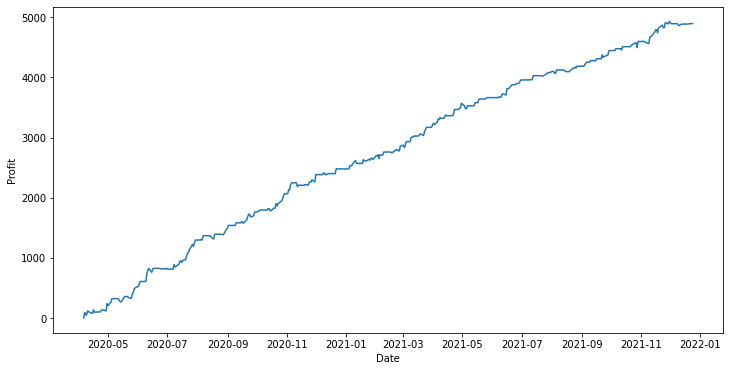

In [196]:
figure = plt.figure(figsize=(12,6))
sns.lineplot(x="Date", y="Profit", data=result_df)

<AxesSubplot:xlabel='Date', ylabel='Price'>

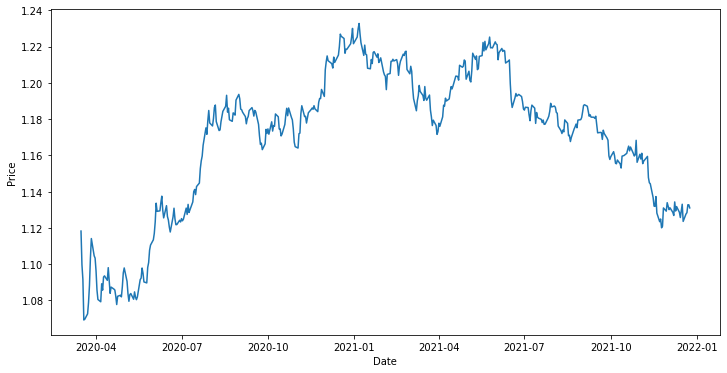

In [201]:
figure = plt.figure(figsize=(12,6))
sns.lineplot(x="Date", y="Price", data=test_df)

In [198]:
expected_net_return = result_df.iloc[-1, 1]

num_years = (pd.to_datetime(END_DATE) - pd.to_datetime(START_DATE)) / timedelta(days=365)

annualised_roi = (expected_net_return / MONEY + 1) ** (1 / num_years) - 1

print(f"Expected Net Return from Mar 2020 - Dec 2021 with $10,000: ${expected_net_return:.2f}")
print(f"Annualised Rate of Return: {annualised_roi * 100:.5f}%")

Expected Net Return from Mar 2020 - Dec 2021 with $10,000: $4896.53
Annualised Rate of Return: 25.12487%


In [ ]:
test_df.iloc[15:,]

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,...,roc,rsi,Bollinger_up,Bollinger_down,cci,diff_n,Bollinger,price_sma,price_ema,Momentum
15,2020-04-06,1.0791,1.0813,1.0835,1.0768,-0.16%,-0.0017,2.0,1.096780,1.079899,...,-0.023085,35.581245,1.134243,1.059317,-64.900443,0.0122,-0.235964,-0.017680,-0.000799,97.842053
16,2020-04-07,1.0889,1.0793,1.0926,1.0783,0.91%,0.0098,2.0,1.094830,1.086823,...,-0.012694,46.799889,1.129423,1.060237,-35.470948,0.0090,-0.085711,-0.005930,0.002077,99.334063
17,2020-04-08,1.0856,1.0891,1.0904,1.0829,-0.30%,-0.0033,0.0,1.092775,1.085882,...,-0.009670,43.833872,1.124128,1.061422,-31.820172,0.0051,-0.114423,-0.007175,-0.000282,100.000000
18,2020-04-09,1.0927,1.0857,1.0953,1.0841,0.65%,0.0071,1.0,1.091495,1.091127,...,0.006540,51.469366,1.120460,1.062530,-5.464806,-0.0092,0.020801,0.001205,0.001573,101.101036
19,2020-04-10,1.0935,1.0930,1.0953,1.0919,0.07%,0.0008,1.0,1.090645,1.092952,...,0.011751,52.312214,1.118226,1.063064,15.089952,-0.0059,0.051757,0.002855,0.000548,101.334445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2021-12-20,1.1275,1.1242,1.1305,1.1234,0.32%,0.0036,0.0,1.128420,1.127084,...,-0.000709,46.839553,1.136446,1.120394,-27.330869,0.0050,-0.057311,-0.000920,0.000416,100.159901
461,2021-12-21,1.1283,1.1277,1.1303,1.1260,0.07%,0.0008,0.0,1.128605,1.128019,...,0.002310,48.373952,1.136429,1.120781,-9.274996,0.0026,-0.019492,-0.000305,0.000281,99.982277
462,2021-12-22,1.1324,1.1279,1.1343,1.1264,0.36%,0.0041,0.0,1.129240,1.131389,...,0.003456,55.900932,1.136011,1.122469,47.075103,0.0024,0.233339,0.003160,0.001011,99.964689
463,2021-12-23,1.1328,1.1325,1.1343,1.1289,0.04%,0.0004,0.0,1.129850,1.132474,...,0.000000,56.613022,1.135439,1.124261,77.106303,-0.0005,0.263916,0.002950,0.000326,100.791885


In [ ]:
temp_x = features.drop(labels= ["Date"] + ["label", "label_3days", "label_5days"] + ["Price"], axis = 1)

In [ ]:
temp_x.columns

Index(['sma', 'ema', 'cma', 'macd', 'macd_s', 'macd_h', 'roc', 'rsi',
       'Bollinger_up', 'Bollinger_down', 'cci'],
      dtype='object')

In [ ]:
temp_x_transformed = loaded_scaler.transform(temp_x)

In [ ]:
np.array_equal(temp_x_transformed, X)

True

In [ ]:
df.tail()

,Date,Price,Open,High,Low,Change %,diff_1,label,sma,ema,...,macd,macd_s,macd_h,roc,rsi,Bollinger_up,Bollinger_down,cci,label_3days,label_5days
2306,2021-12-20,1.1275,1.1242,1.1305,1.1234,0.32%,0.0036,2.0,1.128420,1.127084,...,-0.003948,-0.004795,0.000847,-0.000709,46.839553,1.136446,1.120394,-27.330869,0.0,0.0
2307,2021-12-21,1.1283,1.1277,1.1303,1.1260,0.07%,0.0008,0.0,1.128605,1.128019,...,-0.003696,-0.004575,0.000879,0.002310,48.373952,1.136429,1.120781,-9.274996,0.0,0.0
2308,2021-12-22,1.1324,1.1279,1.1343,1.1264,0.36%,0.0041,2.0,1.129240,1.131389,...,-0.003130,-0.004286,0.001156,0.003456,55.900932,1.136011,1.122469,47.075103,0.0,2.0
2309,2021-12-23,1.1328,1.1325,1.1343,1.1289,0.04%,0.0004,0.0,1.129850,1.132474,...,-0.002618,-0.003952,0.001334,0.000000,56.613022,1.135439,1.124261,77.106303,0.0,1.0
2310,2021-12-24,1.1317,1.1330,1.1344,1.1303,-0.10%,-0.0011,0.0,1.129850,1.131879,...,-0.002276,-0.003617,0.001341,0.006940,53.853702,1.135439,1.124261,73.581941,2.0,2.0
